In [1]:
import os
import numpy as np
import pandas as pd
import re
import json
import requests
import time
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import getpass  # для безопасного ввода токена

from IPython.display import display, HTML, Image

from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
def display_tables_horizontally(*tables):
    html = "<div style='display: flex; gap: 20px;'>"
    for table in tables:
        html += f"<div>{table.to_html(index=False)}</div>"
    html += "</div>"
    display(HTML(html))

In [5]:
auth_key = os.getenv('MAIN_API_KEY')

headers = {
    'Authorization': auth_key,
    'Content-Type': 'application/json',
}

# Маркетинг и продвижение

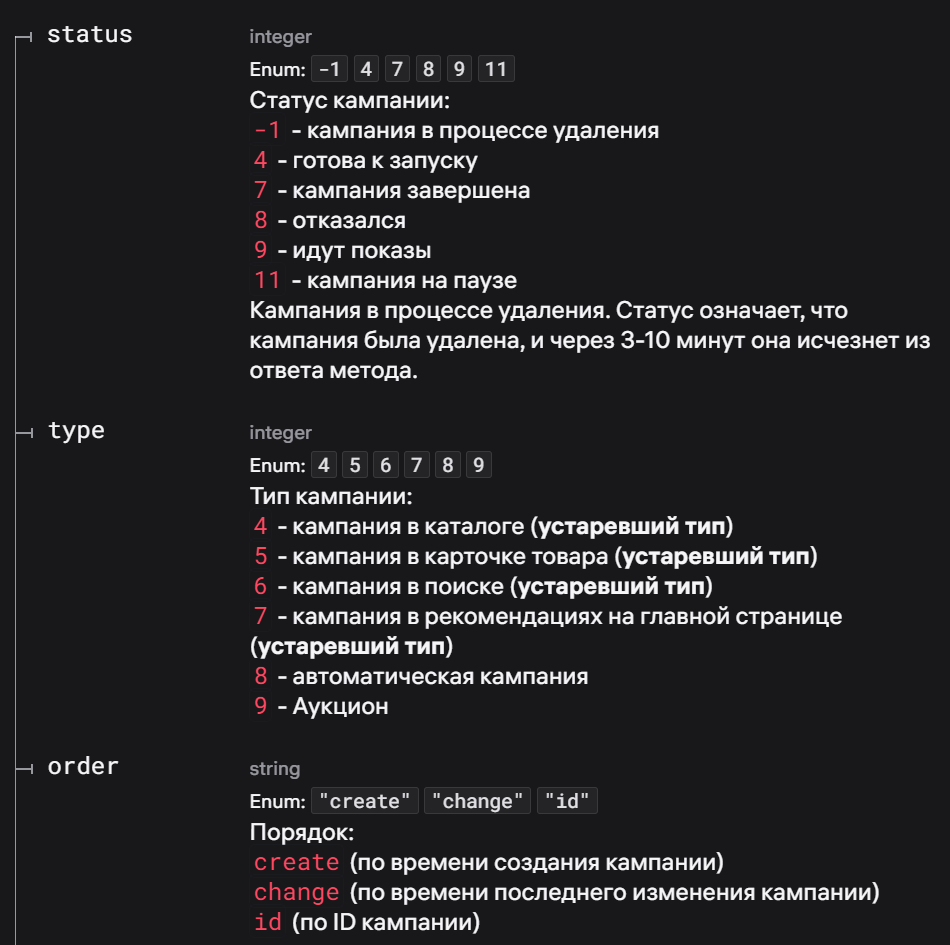

### Списки кампаний
#### https://advert-api.wildberries.ru/adv/v1/promotion/count
**Описание:**
Возвращает списки кампаний, сгруппированных по типу и статусу, с информацией о дате последнего изменения кампании

**Максимум 5 запросов в секунду на один аккаунт продавца**

In [13]:
url = 'https://advert-api.wildberries.ru/adv/v1/promotion/count'

response = requests.get(url=url, headers=headers)
response.raise_for_status()

# Создание плоской таблицы
flat_data = []
for item in response.json()['adverts']:
    for advert in item['advert_list']:
        flat_data.append({
            'type': item['type'],
            'status': item['status'],
            'count': item['count'],
            'advertId': advert['advertId'],
            'changeTime': advert['changeTime']
        })
        
df_promotion_count = pd.DataFrame(flat_data)

df_promotion_count.tail()

,type,status,count,advertId,changeTime
167,5,7,40,7301366,2024-03-06T19:39:26.028342+03:00
168,5,7,40,7301403,2023-08-11T18:26:20.052246+03:00
169,5,7,40,7301716,2024-03-06T19:39:29.63254+03:00
170,5,7,40,7301908,2024-03-06T19:39:35.491038+03:00
171,5,7,40,11271668,2024-03-06T19:39:46.247196+03:00


In [14]:
advertId_list_full = df_promotion_count['advertId'].unique().astype(int).tolist() # Список всех кампаний advertId
df_advert_main = df_promotion_count # Основной датасет рекламы

### Информация о кампаниях
#### https://advert-api.wildberries.ru/adv/v1/promotion/adverts
Возвращает получать информацию о кампаниях по query-параметрам либо по списку ID кампаний

Максимум 5 запросов в секунду на один аккаунт продавца

**Список ID кампаний. Максимум 50.**

In [44]:
# Функция для разбиения списка на батчи
def chunk_list(input_list, batch_size=50):
    '''Разбиение списка на части по заданному размеру.'''
    for i in range(0, len(input_list), batch_size):
        yield input_list[i:i + batch_size]

# Функция для удаления микросекунд
def remove_microseconds(timestamp):
    return re.sub(r'(\.\d+)([+\-]\d{2}:\d{2})$', r'\2', timestamp)

In [46]:
params = {
    'status': None,  # Статус кампании (integer):
                     # -1 - кампания в процессе удаления
                     #  4 - готова к запуску
                     #  7 - кампания завершена
                     #  8 - отказался
                     #  9 - идут показы
                     # 11 - кампания на паузе

    'type': None,    # Тип кампании (integer):
                     #  4 - кампания в каталоге (устаревший тип)
                     #  5 - кампания в карточке товара (устаревший тип)
                     #  6 - кампания в поиске (устаревший тип)
                     #  7 - кампания в рекомендациях на главной странице (устаревший тип)
                     #  8 - автоматическая кампания
                     #  9 - аукцион

    'order': 'create',   # Порядок сортировки (string):
                     # 'create' - по времени создания кампании
                     # 'change' - по времени последнего изменения кампании
                     # 'id'     - по ID кампании

    'direction': 'desc'  # Направление сортировки (string):
                       # 'desc' - от большего к меньшему
                       # 'asc'  - от меньшего к большему
}

url = 'https://advert-api.wildberries.ru/adv/v1/promotion/adverts'

all_data = []
time_columns = ['endTime', 'createTime', 'changeTime', 'startTime']

for batch in chunk_list(input_list=advertId_list_full, batch_size=50): # Размер батча 50
    response = requests.post(url=url, headers=headers, params=params, json=batch)
    try:
        response.raise_for_status() 
        rows = []
        for item in response.json():
            # Базовые поля
            base_row = {
                'endTime': item.get('endTime'),
                'createTime': item.get('createTime'),
                'changeTime': item.get('changeTime'),
                'startTime': item.get('startTime'),
                'name': item.get('name'),
                'dailyBudget': item.get('dailyBudget'),
                'advertId': item.get('advertId'),
                'status': item.get('status'),
                'type': item.get('type'),
                'paymentType': item.get('paymentType'),
                'nms': None,
                'nmCPM': None,
                'cpm': None,
                'subjectName': None,
                'subjectId': None,
                'auction_nm': None,
                'auction_bid': None,
                'united_cpm': None,
                'united_searchCPM': None,
                'united_subjectName': None,
                'united_subjectId': None,
                'united_nms': None
            }
        
            added = False
        
            # Обработка autoParams
            if 'autoParams' in item:
                auto_params = item['autoParams']
                nms = auto_params.get('nms', [])
                nmCPM = auto_params.get('nmCPM', [])
            
                # Если nms равно None, заменяем его на пустой список
                nms = nms if nms is not None else []
            
                # Преобразуем nmCPM в словарь для быстрого доступа
                nmCPM_dict = {entry['nm']: entry['cpm'] for entry in nmCPM}
            
                # Обработка nms и nmCPM одновременно
                for nm in nms:
                    row = base_row.copy()
                    row.update({
                        'nms': nm,
                        'cpm': auto_params.get('cpm'),
                        'subjectName': auto_params.get('subject', {}).get('name'),
                        'subjectId': auto_params.get('subject', {}).get('id'),
                    })
                    # Если nm присутствует в nmCPM, добавляем соответствующий CPM
                    if nm in nmCPM_dict:
                        row.update({
                            'nmCPM': nmCPM_dict[nm]  # CPM из nmCPM
                        })
                    rows.append(row)
                    added = True
            
                # Добавляем строки для nmCPM, которые не включены в nms
                for nm_cpm in nmCPM:
                    if nm_cpm['nm'] not in nms:
                        row = base_row.copy()
                        row.update({
                            'nms': nm_cpm['nm'],
                            'nmCPM': nm_cpm['cpm'],
                            'cpm': auto_params.get('cpm'),
                            'subjectName': auto_params.get('subject', {}).get('name'),
                            'subjectId': auto_params.get('subject', {}).get('id'),
                        })
                        rows.append(row)
                        added = True
        
            # Обработка unitedParams
            if 'unitedParams' in item:
                united_params = item['unitedParams']
                for param in united_params:
                    nms = param.get('nms', [])
                    if nms:
                        for nm in nms:
                            row = base_row.copy()
                            row.update({
                                'nms': nm,
                                'united_cpm': param.get('catalogCPM'),
                                'united_searchCPM': param.get('searchCPM'),
                                'united_subjectName': param.get('subject', {}).get('name'),
                                'united_subjectId': param.get('subject', {}).get('id'),
                                'united_nms': ", ".join(map(str, nms)),
                            })
                            rows.append(row)
                            added = True
        
            # Обработка auction_multibids
            if 'auction_multibids' in item:
                for bid in item['auction_multibids']:
                    row = base_row.copy()
                    row.update({
                        'auction_nm': bid['nm'],
                        'auction_bid': bid['bid'],
                    })
                    rows.append(row)
                    added = True
        
            # Добавляем базовую строку, если ни один список не заполнил строки
            if not added:
                rows.append(base_row)

        df = pd.DataFrame(rows)
        all_data.append(df)
        
    except requests.exceptions.RequestException as e:
        print(f'Ошибка при запросе для батча {batch}: {e}')
    time.sleep(0.2)

# Если были получены данные, выполняем объединение
if all_data:
    df_promotion_adverts = pd.concat(all_data, axis=0, ignore_index=True, sort=False)

    # Работаем со столбцами временными (создаём клонов для удобства работы)
    time_columns = ['endTime', 'createTime', 'changeTime', 'startTime']
    
    # for col in time_columns:
    #     df_promotion_adverts[col] = df_promotion_adverts[col].apply(remove_microseconds)
    #     df_promotion_adverts[col] = pd.to_datetime(df_promotion_adverts[col], errors='coerce')
    
    #     df_promotion_adverts[f'{col}_date'] = df_promotion_adverts[col].dt.date
    #     df_promotion_adverts[f'{col}_datetime'] = df_promotion_adverts[col].dt.strftime('%Y-%m-%dT%H:%M:%S')
    #     df_promotion_adverts[f'{col}_timezone'] = df_promotion_adverts[col].dt.tz

df_promotion_adverts.tail()

/var/folders/y5/hs9hx8vd5qz47th8r8718p080000gn/T/ipykernel_4879/2799227901.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_promotion_adverts = pd.concat(all_data, axis=0, ignore_index=True, sort=False)


,endTime,createTime,changeTime,startTime,name,dailyBudget,advertId,status,type,paymentType,nms,nmCPM,cpm,subjectName,subjectId,auction_nm,auction_bid,united_cpm,united_searchCPM,united_subjectName,united_subjectId,united_nms
390,2023-09-15T05:18:48.734513+03:00,2022-11-03T02:58:54.876873+03:00,2023-08-01T04:26:21.38911+03:00,2023-07-13T01:01:45.193284+03:00,top,0,3420661,7,5,,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
391,2023-02-14T17:36:00.46572+03:00,2022-10-30T23:59:21.347377+03:00,2022-12-31T14:02:05.554021+03:00,2022-12-30T17:03:12.146775+03:00,kingnuos_2,0,3387417,7,5,,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
392,2022-12-15T19:18:09.011823+03:00,2022-10-30T23:57:01.998657+03:00,2022-10-31T17:48:21.177664+03:00,2022-10-30T23:57:17.034334+03:00,shengke_13_diamond_black,0,3387409,7,5,,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
393,2023-01-22T11:08:27.005852+03:00,2022-10-29T00:16:42.426409+03:00,2022-12-08T00:17:43.096613+03:00,2022-12-07T01:25:00.832839+03:00,shengke_8,0,3371890,7,5,,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
394,2022-12-23T22:48:40.773862+03:00,2022-10-18T00:57:17.56991+03:00,2022-11-08T18:08:33.169562+03:00,2022-11-08T02:36:27.940973+03:00,zip_paketiki,0,3248898,7,5,,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None


# Аналитика и данные

## Статистика по продвижению

### Статистика кампаний
#### /adv/v2/fullstats

Возвращает статистику кампаний. Данные вернутся для кампаний в статусах:

7 — завершено,
9 — приостановлена продавцом,
11 — пауза по расходу бюджета

Максимум 1 запрос в минуту на один аккаунт продавца

In [17]:
# # Возвращает данные за последние сутки
# advertId_list = [
#     {'id': 13925291},
#     {'id': 12981582},
#     {'id': 14033391},
# ]

# # Возвращает данные в определённые даты (почему-то не работает)
# advertId_list = [
#     {
#         'id': 13925291,
#         'dates': ['2024-12-10', '2024-12-17']
#     },
#     {
#         'id': 12981582,
#         'dates': ['2024-12-10', '2024-12-17']
#     },
#     {
#         'id': 14033391,
#         'dates': ['2024-12-10', '2024-12-17']
#     }
# ]

# # Возвращает данные в определённый интервал дат
# advertId_list = [
#     {
#         'id': 13925291,
#         'interval': {'begin': '2024-12-10', 'end': '2024-12-17'}
#     },
#     {
#         'id': 12981582,
#         'interval': {'begin': '2024-12-10', 'end': '2024-12-17'}
#     },
#     {
#         'id': 14033391,
#         'interval': {'begin': '2024-12-10', 'end': '2024-12-17'}
#     }
# ]

In [19]:
def create_advert_list(date_from, date_to, advert_ids):
    """
    Создает список словарей для рекламных кампаний с заданными интервалами.

    :param begin_date: Начальная дата (string, формат YYYY-MM-DD).
    :param end_date: Конечная дата (string, формат YYYY-MM-DD).
    :param advert_ids: Список ID рекламных кампаний (list of integers).
    :return: Список словарей для рекламных кампаний.
    """
    # Создаем список с заданной структурой
    advert_list = [
        {"id": advert_id, "interval": {"begin": date_from, "end": date_to}}
        for advert_id in advert_ids
    ]
    return advert_list

In [251]:
date_from = datetime.strptime('2025-02-04', '%Y-%m-%d')
date_to = datetime.strptime('2025-03-22', '%Y-%m-%d')
# date_to = datetime.strptime(datetime.now().strftime('%Y-%m-%d'), '%Y-%m-%d')
wait_long = True  # Если False, ограничиваем 31 днями и убираем ожидания

if not wait_long:
    date_from = max(date_to - timedelta(days=31), date_from)

# Разбиваем на интервалы по 31 день
all_data = []  # Для хранения результатов
while date_from < date_to:
    # Определяем конец текущего интервала
    interval_end = min(date_from + timedelta(days=31), date_to)

    # Создаём задачу
    advertId_list = create_advert_list(date_from=date_from.strftime('%Y-%m-%d'), date_to=interval_end.strftime('%Y-%m-%d'), advert_ids=advertId_list_full)
    url = f'https://advert-api.wildberries.ru/adv/v2/fullstats'
    response = requests.post(url=url, headers=headers, json=advertId_list)
    response.raise_for_status()

    # Преобразуем данные в DataFrame и добавляем к общему списку
    df_chunk = pd.json_normalize(response.json())
    all_data.append(df_chunk)

    # Сдвигаем начало интервала
    date_from = interval_end + timedelta(days=1)

    # Ждём перед созданием следующей задачи только в случае ожидания полного цикла
    if wait_long and date_from < date_to:
        time.sleep(60)
        print(f'Last used date: {interval_end.strftime('%d.%m.%Y')}')

# Объединяем все данные в один DataFrame
df_adv_fullstats = pd.concat(all_data, ignore_index=True)

Last used date: 07.03.2025


In [178]:
# days_col = df_adv_fullstats[df_adv_fullstats['advertId'] == 12950836]['days'].iloc[0]

# # Сохраняем в файл
# with open('days_col.json', 'w', encoding='utf-8') as f:
#     json.dump(days_col, f, ensure_ascii=False, indent=4)

# boosterStats_col = df_adv_fullstats[df_adv_fullstats['advertId'] == 12950836]['boosterStats'].iloc[0]

# # Сохраняем в файл
# with open('boosterStats_col.json', 'w', encoding='utf-8') as f:
#     json.dump(boosterStats_col, f, ensure_ascii=False, indent=4)

In [252]:
# Группировка данных
df_grouped = df_adv_fullstats.groupby('advertId').agg({
    'views': 'min',  # Просмотры за выбранный период
    'clicks': 'sum',  # Клики за выбранный период
    'sum': 'sum',  # Затраты за выбранный период
    'orders': 'sum',  # Заказы за выбранный период
    'sum_price': 'sum',  # Сумма заказов за выбранный период
    'atbs': 'sum',  # Добавления в корзину за выбранный период
    'shks': 'sum',  # Заказанные товары (штуки) за выбранный период
    'days': lambda x: [item for sublist in x if isinstance(sublist, list) for item in sublist],  # Объединенная статистика по дням
    'boosterStats': lambda x: [item for sublist in x if isinstance(sublist, list) for item in sublist],  # Объединенная статистика по позициям
    'interval.begin': 'min',  # Начало периода
    'interval.end': 'max'  # Конец периода
}).reset_index()

# Пересчет относительных метрик
df_grouped['ctr'] = (df_grouped['clicks'] / df_grouped['views']) * 100  # CTR = (clicks / views) * 100 (в процентах)
df_grouped['cpc'] = df_grouped['sum'] / df_grouped['clicks']  # CPC = sum / clicks (средняя стоимость клика в рублях)
df_grouped['cr'] = (df_grouped['orders'] / df_grouped['clicks']) * 100  # CR = (orders / atbs) * 100 (в процентах)

# Разворачиваем столбец days и переименовываем столбцы
days_expanded = df_grouped.explode('days')  # Разворачиваем days (список)
days_df = pd.json_normalize(days_expanded['days']).add_suffix('_day') # Отдельно берём столбец со словарями (json) и разворачиваем его + добавляем суффикс
days_df['date_day'] = pd.to_datetime(days_df['date_day']).dt.strftime('%Y-%m-%d')
days_expanded = pd.concat([days_expanded.drop(columns=['days']).reset_index(drop=True), 
                           days_df.reset_index(drop=True)], axis=1) # Конкатим справа полученные данные (размерности совпадают после explode)

# Разворачиваем apps и переименовываем столбцы
apps_expanded = days_expanded.explode('apps_day')  # Разворачиваем apps
apps_df = pd.json_normalize(apps_expanded['apps_day']).add_suffix('_device')
apps_expanded = pd.concat([apps_expanded.drop(columns=['apps_day']).reset_index(drop=True),
                           apps_df.reset_index(drop=True)], axis=1)

# Разворачиваем nm внутри apps и переименовываем столбцы
nm_expanded = apps_expanded.explode('nm_device')  # Разворачиваем nm
nm_df = pd.json_normalize(nm_expanded['nm_device']).add_suffix('_nm')
nm_expanded = pd.concat([
    nm_expanded.drop(columns=['nm_device']).reset_index(drop=True),
    nm_df.reset_index(drop=True)
], axis=1)

# Разворачиваем boosterStats и нормализуем
booster_expanded = pd.json_normalize(df_grouped.explode('boosterStats')['boosterStats']).add_suffix('_booster')
booster_expanded['date_booster'] = pd.to_datetime(booster_expanded['date_booster']).dt.strftime('%Y-%m-%d')  # Нормализуем дату

# Разворачиваем boosterStats и сохраняем advertId
booster_expanded = df_grouped.explode('boosterStats')  # Разворачиваем boosterStats
booster_expanded = pd.concat([
    booster_expanded[['advertId']].reset_index(drop=True),  # Сохраняем advertId
    pd.json_normalize(booster_expanded['boosterStats']).add_suffix('_booster').reset_index(drop=True)  # Нормализуем boosterStats
], axis=1)

# Нормализуем дату внутри кода
booster_expanded['date_booster'] = pd.to_datetime(booster_expanded['date_booster']).dt.strftime('%Y-%m-%d')  # Преобразуем и форматируем дату

# Объединяем данные по датам и advertId
df_adv_fullstats_preprocessed = pd.merge(
    nm_expanded.drop('boosterStats', axis=1),
    booster_expanded,
    left_on=['date_day', 'advertId'],
    right_on=['date_booster', 'advertId'],
    how='left',
    suffixes=('_day', '_booster')
)

# Заполняем пропущенные значения
# final_data = final_data.fillna(value=np.nan)

# Убираем дубликаты, если они есть
df_adv_fullstats_preprocessed = df_adv_fullstats_preprocessed.drop_duplicates(subset=['date_day', 'advertId', 'appType_device', 'nmId_nm']).reset_index(drop=True)
df_adv_fullstats_preprocessed.tail(2)

,advertId,views,clicks,sum,orders,sum_price,atbs,shks,interval.begin,interval.end,ctr,cpc,cr,date_day,views_day,clicks_day,ctr_day,cpc_day,sum_day,atbs_day,orders_day,cr_day,shks_day,sum_price_day,views_device,clicks_device,ctr_device,cpc_device,sum_device,atbs_device,orders_device,cr_device,shks_device,sum_price_device,appType_device,views_nm,clicks_nm,ctr_nm,cpc_nm,sum_nm,atbs_nm,orders_nm,cr_nm,shks_nm,sum_price_nm,name_nm,nmId_nm,date_booster,nm_booster,avg_position_booster
668,19307017,7,0,0.22,0,0,0,0,2025-02-04,2025-03-07,0.0,inf,NaN,2025-02-22,1,0,0.0,0.0,0.03,0,0,0.0,0,0,1,0,0.0,0.0,0.03,0,0,0.0,0,0,64,1,0,0.0,0.0,0.03,0,0,0.0,0,0,Часы наручные классические механические кварцевые,146009251,NaN,NaN,NaN
669,19307017,7,0,0.22,0,0,0,0,2025-02-04,2025-03-07,0.0,inf,NaN,2025-03-07,1,0,0.0,0.0,0.04,0,0,0.0,0,0,1,0,0.0,0.0,0.00,0,0,0.0,0,0,32,1,0,0.0,0.0,0.04,0,0,0.0,0,0,Часы наручные классические механические кварцевые,128344350,NaN,NaN,NaN


In [253]:
df_adv_fullstats_preprocessed[df_adv_fullstats_preprocessed['advertId'] == 12950285][['date_day', 
                                                                                      'views_day', 
                                                                                      'clicks_day', 
                                                                                      'avg_position_booster']].drop_duplicates()

,date_day,views_day,clicks_day,avg_position_booster
0,2025-02-04,21,1,149.0
2,2025-02-05,11,2,NaN
4,2025-02-06,4,0,NaN
5,2025-02-07,2,0,NaN
7,2025-02-08,4,0,NaN
9,2025-02-09,2,0,NaN
11,2025-02-10,4,0,NaN
13,2025-02-11,1,0,NaN
14,2025-02-12,1,0,NaN
15,2025-02-14,1,0,NaN


In [254]:
df_groupped_by_advertId = df_adv_fullstats_preprocessed.groupby(['advertId', 'nmId_nm']).agg({
    'sum_nm': 'sum',
    'views_nm': 'sum',
    'clicks_nm': 'sum',
    'orders_nm': 'sum',
    'sum_price_nm': 'sum',
}).reset_index().sort_values(by='sum_nm', ascending=False)

df_groupped_by_advertId = pd.merge(df_groupped_by_advertId, df_promotion_adverts[['advertId', 'name']].drop_duplicates(), how='left', on='advertId')
df_groupped_by_advertId

,advertId,nmId_nm,sum_nm,views_nm,clicks_nm,orders_nm,sum_price_nm,name
0,12950836,154103439,117399.88,1243430,42778,322,894689,sinobi_3_woman_golden
1,13080155,122357681,45694.42,463305,20689,49,131311,shengke_7_circle_black_silver
2,12981582,82190806,21099.54,195900,3454,24,44250,shengke2_silver-white
3,12963615,146015370,20362.47,193060,5300,19,41713,shengke_10_black
4,12950285,117479301,2083.75,18615,555,1,2299,shengke_7_circle_black_golden
5,13955702,117479301,1978.53,20882,764,1,2887,shengke_7_circle_black_golden_карточка
6,13958175,85247854,1956.91,18087,341,2,5324,shengke2_green
7,12981618,128017415,1546.30,17416,529,1,2058,kingnuos_2_silver_black
8,14250805,154103440,1469.50,13789,335,3,8601,sinobi_3_woman_black_бустер+карточка
9,12963419,128344350,1342.79,14261,523,1,2025,kingnuos_2_silver_blue


In [269]:
df_groupped_by_advertId = df_adv_fullstats_preprocessed.groupby(['advertId', 'nmId_nm']).agg({
    'sum_nm': 'sum',
    'views_nm': 'sum',
    'clicks_nm': 'sum',
    'orders_nm': 'sum',
    'sum_price_nm': 'sum',
}).reset_index().sort_values(by='sum_nm', ascending=False)

df_groupped_by_advertId = pd.merge(df_groupped_by_advertId, df_promotion_adverts[['advertId', 'name']].drop_duplicates(), how='left', on='advertId')

df_groupped_by_advertId = pd.merge(df_groupped_by_advertId, df_supplier_orders_groupped, how='left', left_on='nmId_nm', right_on='nmId')
df = df_groupped_by_advertId.groupby(['nmId_nm', 'supplierArticle']).agg({
    'sum_nm': 'sum',
    'views_nm': 'sum',
    'clicks_nm': 'sum',
    'orders_nm': 'sum',
    'sum_price_nm': 'sum',
    'priceWithDisc': 'sum',
    'name': 'first',
    'advertId': 'first'
}).reset_index().sort_values(by='sum_nm', ascending=False)

df['drr'] = df['sum_nm'] / df['sum_price_nm'] * 100
df

,nmId_nm,supplierArticle,sum_nm,views_nm,clicks_nm,orders_nm,sum_price_nm,priceWithDisc,name,advertId,drr
12,154103439,sinobi_3_woman_golden,117402.69,1243507,42779,322,894689,287083.50,sinobi_3_woman_golden,12950836,13.122179
6,122357681,shengke_7_circle_black_silver,45694.42,463305,20689,49,131311,25627.80,shengke_7_circle_black_silver,13080155,34.798623
0,82190806,shengke2_silver-white,21099.54,195900,3454,24,44250,23203.58,shengke2_silver-white,12981582,47.682576
11,146015370,shengke_10_black,20362.47,193060,5300,19,41713,21285.00,shengke_10_black,12963615,48.815645
4,117479301,shengke_7_circle_black_golden,4062.28,39497,1319,2,5186,22110.00,shengke_7_circle_black_golden,12950285,78.331662
1,85247854,shengke2_green,1956.91,18087,341,2,5324,24943.50,shengke2_green,13958175,36.756386
7,128017415,kingnuos_2_silver_black,1546.30,17416,529,1,2058,9045.00,kingnuos_2_silver_black,12981618,75.136054
13,154103440,sinobi_3_woman_black,1469.50,13789,335,3,8601,18371.10,sinobi_3_woman_black_бустер+карточка,14250805,17.085223
8,128344350,kingnuos_2_silver_blue,1342.92,14265,523,1,2025,36180.00,kingnuos_2_silver_blue,12963419,66.317037
5,117479406,shengke_7_circle_silver_black,329.30,3087,99,0,0,7151.10,shengke_7_circle_silver_black,13049055,inf


In [271]:
df['sum_nm'].sum()

215267.03999999998

In [273]:
df['sum_price_nm'].sum()*0.72*0.93*0.6

456060.67631999997

In [275]:
df[df['supplierArticle'] == 'sinobi_3_woman_golden']['sum_nm'].sum()

117402.69

In [277]:
df[df['supplierArticle'] == 'sinobi_3_woman_golden']['sum_price_nm'].sum()*0.72*0.93*0.6

359450.25263999996

In [279]:
df[df['supplierArticle'] != 'sinobi_3_woman_golden']['sum_nm'].sum()

97864.34999999999

In [281]:
df[df['supplierArticle'] != 'sinobi_3_woman_golden']['sum_price_nm'].sum()*0.72*0.93*0.6

96610.42368

In [101]:
df_supplier_orders[
    (df_supplier_orders['date'] >= '2025-01-13T00:00:00') & 
    (df_supplier_orders['date'] < '2025-01-20T00:00:00')
].shape

(173, 28)

In [94]:
df_supplier_orders_groupped = df_supplier_orders[
    (df_supplier_orders['date'] >= '2025-04-20T00:00:00') & 
    (df_supplier_orders['date'] < '2025-04-26T00:00:00')
].groupby('nmId').agg({
    'finishedPrice': 'sum',
    'priceWithDisc': 'sum',
    'supplierArticle': 'first'
}).reset_index()

df_supplier_orders_groupped.head()

,nmId,finishedPrice,priceWithDisc,supplierArticle
0,76741196,4728.00,6100.00,1rose-gold
1,82190806,18010.06,23203.58,shengke2_silver-white
2,84979561,2340.00,3000.00,1Shengke_leather_black
3,84979562,2340.00,3000.00,1shengke_leather_blue
4,85247854,19361.00,24943.50,shengke2_green


In [60]:
tbl = pd.merge(
    final_data.groupby('nmId_nm').agg({
    'sum_nm': 'sum',
    'sum_price_nm': 'sum',
}).reset_index(),
    df_supplier_orders.groupby('nmId').agg({
    'finishedPrice': 'sum',
    'priceWithDisc': 'sum',
    'supplierArticle': 'first'
}).reset_index(),
    left_on=['nmId_nm'],
    right_on=['nmId'],
    how='outer',
    suffixes=('_aaaa', '_bbbbb')
).sort_values(by='sum_nm', ascending=False)


tbl['drr'] = tbl['sum_nm'] / tbl['sum_price_nm'] * 100
tbl.sort_values(by='drr', ascending=False).head(20)

NameError: name 'final_data' is not defined

In [85]:
pd.merge(final_data.groupby('nmId_nm').agg({
    'sum_nm': 'sum',
}).reset_index().sort_values(by='sum_nm', ascending=False).head()

,nmId_nm,sum_nm
37,154103439,81394.38
24,117479301,50544.33
2,82190806,46047.62
35,146015370,32412.72
28,122357681,25522.67


In [90]:
df_supplier_orders.groupby('nmId').agg({
    'finishedPrice': 'sum',
    'priceWithDisc': 'sum',
    'supplierArticle': 'first'
}).reset_index().sort_values(by='finishedPrice', ascending=False)

,nmId,finishedPrice,priceWithDisc,supplierArticle
96,154103439,3398069.28,4289240.23,sinobi_3_woman_golden
7,82190806,1063739.61,1340895.31,shengke2_silver-white
72,146015370,762354.64,967847.56,shengke_10_black
54,117479301,639474.21,810638.93,shengke_7_circle_black_golden
97,154103440,490198.32,620441.37,sinobi_3_woman_black
...,...,...,...,...
79,150590252,1310.00,1598.00,bag_1_wine_red
20,100377682,870.00,1049.00,watchred
39,114027520,810.00,900.00,silver_choker
2,76577610,678.00,870.00,Pearl1Pearl_white


In [119]:
df_supplier_orders[(pd.to_datetime(df_supplier_orders['date']) >= pd.to_datetime('2024-12-01')) & (df_supplier_orders['isRealization'] == True)]['priceWithDisc'].sum()

6967257.74

In [95]:
nm_expanded['sum_nm'].sum()

411747.81

In [96]:
df_adv_fullstats['sum'].sum()

411747.66000000003

In [97]:
final_data['sum_nm'].sum()

411747.81

### Статистика автоматической кампании по кластерам фраз
#### /adv/v2/auto/stat-words
Возвращает кластеры ключевых (наборы похожих) фраз, по которым показывались товары в кампании, и количество показов по ним. В ответ метода попадают только те фразы, по которым товары показывались хотя бы один раз. Информация обновляется раз в 15 минут

In [180]:
params = {
    'id': 12950836,  # ID кампании (integer):
}

url = f'https://advert-api.wildberries.ru/adv/v2/auto/stat-words'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

df_auto_stat_words_cluster_count = pd.DataFrame(response.json()['clusters'])[['cluster', 'count']]
df_auto_stat_words_cluster_keyword = pd.DataFrame(response.json()['clusters'])[['cluster', 'keywords']].explode('keywords').reset_index(drop=True)

display_tables_horizontally(df_auto_stat_words_cluster_count.head(), df_auto_stat_words_cluster_keyword.head())

cluster,count
часы наручные женский,641782
часы женские,156389
часы наручные женские механические,155654
часы женские механические,94048
час,80985
cluster,keywords
часы наручные женский,",женские часы наручные"
часы наручные женский,",часы женские на руку"
часы наручные женский,",часы женские ручные.часы женские ручные."
часы наручные женский,",часы наручные женские"


In [17]:
df_auto_stat_words_cluster_count.shape, df_auto_stat_words_cluster_keyword.shape

((661, 2), (27077, 2))

### Статистика поисковой кампании по ключевым фразам
#### /adv/v1/stat/words
Возвращает статистику поисковой кампании по ключевым фразам.
Информация обновляется каждые 30 минут

In [18]:
params = {
    'id': 14033391,  # ID кампании (integer):
}

url = f'https://advert-api.wildberries.ru/adv/v1/stat/words'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

fixed_flag = response.json()['words']['fixed'] # Bool

response.json()

{'words': {'phrase': [],
  'strong': [],
  'excluded': [],
  'pluse': ['часы женские под золото',
   'часы женские золотистые',
   'часы женские механические золотые',
   'часы женские ручные',
   'золотые часы',
   'часы женские наручные с браслетом с цифрами',
   'часы женские механические на ремешке',
   'часыженские наручные',
   'часы наручные женские золотые',
   'часы под золото женские',
   'часы для женщин',
   'часы женские маленькие',
   'часы женские кварцевые',
   'женские японские часы',
   'часы женские наручные кварцевые с браслетом',
   'часы денские',
   'часы женские',
   'золотые часы женские',
   'часы женские золото',
   'часы наручные женский',
   'часы женские механические классические',
   'часы наручные женские кварцевые',
   'часы женские наручные механические золотые',
   'часы женские наручные маленькие под золото',
   'женский часы',
   'часы женские с золотым ремешком',
   'часы ручные женские',
   'часы женское',
   'часы женские механические стильные',


In [19]:
response.json()['words'].keys()

dict_keys(['phrase', 'strong', 'excluded', 'pluse', 'keywords', 'fixed'])

In [20]:
pd.DataFrame(response.json()['words']['excluded'])

""


In [21]:
fixed_flag = response.json()['words']['fixed']

In [22]:
df_search_stat_words = response.json()

### Статистика по ключевым фразам
#### adv/v0/stats/keywords
Метод формирует статистику по ключевым фразам из поисковой строки: количество просмотров товара и затраты по одной ключевой фразе. Подходит для автоматических кампаний и Аукционов.

Статистика формируется за каждый день, когда кампания была активна. В одном запросе можно получить данные максимум за 7 дней.
Данные обновляются каждый час.

Максимум 4 запроса в секунду на один аккаунт продавца

In [261]:
advert_id = 12950836
start_date = '2025-02-04'
end_date = '2025-03-22'
wait_long = True  # True — обходим весь период по 7 дней, False — только последние 7 дней


# === Подготовка дат ===
date_from = datetime.strptime(start_date, '%Y-%m-%d')
date_to = datetime.strptime(end_date, '%Y-%m-%d')

url = 'https://advert-api.wildberries.ru/adv/v0/stats/keywords'
all_chunks = []
max_window = timedelta(days=7)
short_pause = 0.26  # чтобы не превышать 4 запроса в секунду

# === Основная логика ===
if not wait_long:
    # Только последние до 7 дней
    date_from = max(date_to - timedelta(days=6), date_from)

# Подаём на вход while один раз (или много раз — зависит от wait_long)
while date_from <= date_to:
    window_end = min(date_from + max_window - timedelta(days=1), date_to)

    params = {
        'advert_id': advert_id,
        'from': date_from.strftime('%Y-%m-%d'),
        'to': window_end.strftime('%Y-%m-%d'),
    }

    response = requests.get(url=url, headers=headers, params=params)
    response.raise_for_status()

    data = response.json().get('keywords', [])
    if data:
        all_chunks.append(pd.json_normalize(data))

    # Если wait_long=True — сдвигаемся дальше по диапазону
    if wait_long:
        date_from = window_end + timedelta(days=1)
        time.sleep(short_pause)
    else:
        # Если wait_long=False — только один проход
        break

# === Склейка в единый DataFrame ===
if all_chunks:
    df = pd.concat(all_chunks, ignore_index=True)
else:
    df = pd.DataFrame()



# Разворачиваем stats
df_stats = df.explode('stats').reset_index(drop=True)
df_stats['stats'] = df_stats['stats'].apply(lambda x: x if isinstance(x, dict) else {})
df_stats = pd.concat([df_stats.drop(['stats'], axis=1), df_stats['stats'].apply(pd.Series)], axis=1)

# 1) Агрегация по дням
df_daily = df_stats.groupby('date').agg({
    'views': 'sum',
    'clicks': 'sum',
    'sum': 'sum'
}).reset_index()
df_daily['ctr'] = (df_daily['clicks'] / df_daily['views']) * 100

# 2) Агрегация по ключевым словам
df_keywords = df_stats.groupby('keyword').agg({
    'views': 'sum',
    'clicks': 'sum',
    'sum': 'sum'
}).reset_index()
df_keywords['ctr'] = (df_keywords['clicks'] / df_keywords['views']) * 100
df_keywords = df_keywords.sort_values(by='views', ascending=False).reset_index(drop=True)

In [262]:
df_daily

,date,views,clicks,sum,ctr
0,2025-02-04,10438,253,1211.09,2.423836
1,2025-02-05,12567,284,1457.93,2.259887
2,2025-02-06,11994,296,1391.50,2.467901
3,2025-02-07,12759,292,1480.35,2.288581
4,2025-02-08,13322,348,1545.64,2.612220
5,2025-02-09,16510,450,1915.40,2.725621
6,2025-02-10,13812,340,1602.37,2.461628
7,2025-02-11,14548,324,1687.81,2.227110
8,2025-02-12,15419,318,1788.79,2.062391
9,2025-02-13,13522,294,1568.71,2.174235


In [263]:
df_keywords.head(30)

,keyword,views,clicks,sum,ctr
0,часы наручные женский,250299,6669,29536.68,2.664413
1,часы женские,55876,1640,6590.85,2.935071
2,час,45341,797,5308.67,1.757791
3,часы наручные женские механические,40756,1735,4819.98,4.257042
4,часы женские механические,21418,819,2534.32,3.823886
5,наручные часы,21167,349,2495.40,1.648793
6,часы женские золотые,12989,554,1536.72,4.265147
7,золотые часы,10145,383,1198.88,3.775259
8,часы механические,7467,165,881.65,2.209723
9,часы наручные женские с браслетом,7082,163,836.48,2.301610


# Отчёты

## Основные отчёты

### Поставки
#### /api/v1/supplier/incomes
Максимум 1 запрос в минуту на один аккаунт продавца

In [23]:
params = {
    'dateFrom': '2024-01-01T15:04:05Z', # Дата и время последнего изменения по поставке. Дата в формате RFC3339. Время передаётся в часовом поясе Мск (UTC+3).
}

url = f'https://statistics-api.wildberries.ru/api/v1/supplier/incomes'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

df_supplier_incomes = pd.DataFrame(response.json())
df_supplier_incomes.tail()

,incomeId,number,date,lastChangeDate,supplierArticle,techSize,barcode,quantity,totalPrice,dateClose,warehouseName,nmId,status
509,25664744,,2024-12-15T00:00:00,2024-12-15T08:25:33,shengke_10_black,0,2037456080896,215,0,2024-12-15T00:00:00,Коледино,146015370,Принято
510,25664744,,2024-12-15T00:00:00,2024-12-15T08:25:33,kingnuos_6_black,0,2037601080771,100,0,2024-12-15T00:00:00,Коледино,151605976,Принято
511,25664744,,2024-12-15T00:00:00,2024-12-15T08:25:33,sinobi_3_woman_golden,0,2037647326154,200,0,2024-12-15T00:00:00,Коледино,154103439,Принято
512,25664744,,2024-12-15T00:00:00,2024-12-15T08:25:33,sinobi_3_woman_black,0,2037647329322,34,0,2024-12-15T00:00:00,Коледино,154103440,Принято
513,25664744,,2024-12-15T00:00:00,2024-12-15T08:25:33,shengke3_black_metall,0,2040811333629,30,0,2024-12-15T00:00:00,Коледино,115291966,Принято


### Склады
#### /api/v1/supplier/stocks
Метод предоставляет количество остатков товаров на складах WB.
Данные обновляются раз в 30 минут.

Максимум 1 запрос в минуту на один аккаунт продавца

In [24]:
params = {
    'dateFrom': '2024-01-01T15:04:05Z', # Дата и время последнего изменения по товару. Для получения полного остатка следует указывать максимально раннее значение. Дата в формате RFC3339. Время передаётся в часовом поясе Мск (UTC+3).
}

url = f'https://statistics-api.wildberries.ru/api/v1/supplier/stocks'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

df_supplier_stocks = pd.DataFrame(response.json())
df_supplier_stocks.tail()

,lastChangeDate,warehouseName,supplierArticle,nmId,barcode,quantity,inWayToClient,inWayFromClient,quantityFull,category,subject,brand,techSize,Price,Discount,isSupply,isRealization,SCCode
393,2025-01-17T22:31:24,Коледино,shengke_10_black,146015370,2037456080896,93,8,2,103,Аксессуары,Часы наручные,BRIGHT SIDE,0,4500,29,True,False,Tech
394,2025-01-17T22:36:41,Казань,shengke4_zirconicfullgolden,115293796,2040812520622,1,0,0,1,Аксессуары,Часы наручные,BRIGHT SIDE,0,5000,23,True,False,Tech
395,2025-01-17T22:36:41,СЦ Челябинск 2,shengke4_zirconicfullgolden,115293796,2040812520622,0,1,0,1,Аксессуары,Часы наручные,BRIGHT SIDE,0,5000,23,True,False,Tech
396,2025-01-17T22:39:55,Коледино,shengke2_green,85247854,2033237660622,2,6,3,11,Аксессуары,Часы наручные,BRIGHT SIDE,0,5000,24,True,False,Tech
397,2025-01-17T22:39:55,Электросталь,shengke2_green,85247854,2033237660622,23,0,0,23,Аксессуары,Часы наручные,BRIGHT SIDE,0,5000,24,True,False,Tech


### Заказы
#### /api/v1/supplier/orders
Метод предоставляет информацию обо всех заказах.
Данные обновляются раз в 30 минут.


1 строка = 1 заказ = 1 cборочное задание = 1 единица товара.
Для определения заказа рекомендуем использовать поле srid.


Информация о заказе хранится 90 дней с момента оформления.

Максимум 1 запрос в минуту на один аккаунт продавца

In [54]:
params = {
    'dateFrom': '2025-01-01T00:00:00Z', # Дата и время последнего изменения по заказу. Дата в формате RFC3339. Время передаётся в часовом поясе Мск (UTC+3).
    'flag': 0 # Если параметр flag=0 то все строки lastChangeDate >= dateFrom. Если параметр flag=1, то только на дату dateFrom.
}

url = f'https://statistics-api.wildberries.ru/api/v1/supplier/orders'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

df_supplier_orders = pd.DataFrame(response.json())
df_supplier_orders.tail()

,date,lastChangeDate,warehouseName,warehouseType,countryName,oblastOkrugName,regionName,supplierArticle,nmId,barcode,category,subject,brand,techSize,incomeID,isSupply,isRealization,totalPrice,discountPercent,spp,finishedPrice,priceWithDisc,isCancel,cancelDate,orderType,sticker,gNumber,srid
3682,2025-04-27T21:50:18,2025-04-27T21:57:14,Подольск,Склад WB,Россия,Приволжский федеральный округ,Самарская область,sinobi_3_woman_golden,154103439,2037647326154,Аксессуары,Часы наручные,BRIGHT SIDE,0,0,False,True,5500,35,21,2824.0,3575.0,False,0001-01-01T00:00:00,Клиентский,,2206305497086002443,4824584926439047348.3.0
3683,2025-04-27T21:50:18,2025-04-27T21:57:14,Коледино,Склад WB,Россия,Приволжский федеральный округ,Самарская область,gold,119906075,2044176648626,Аксессуары,Часы наручные,BRIGHT SIDE,0,0,False,True,5000,30,21,2765.0,3500.0,False,0001-01-01T00:00:00,Клиентский,,2206305497086002443,4824584926439047348.1.0
3684,2025-04-17T23:06:45,2025-04-27T22:42:45,Казань,Склад WB,Россия,Приволжский федеральный округ,Республика Татарстан,shengke2_full_black_silver_edging,88607864,2035223597622,Аксессуары,Часы наручные,BRIGHT SIDE,0,25664744,False,True,5000,27,22,2847.0,3650.0,True,2025-04-27T00:00:00,Клиентский,27734069338,93170584607997206095,8992704223390598864.0.0
3685,2025-04-20T13:03:47,2025-04-27T22:43:36,Виртуальный Барнаул,Склад WB,Россия,Сибирский федеральный округ,Алтайский край,sinobi_3_woman_golden,154103439,2037647326154,Аксессуары,Часы наручные,BRIGHT SIDE,0,27474322,False,True,5500,32,22,2917.0,3740.0,True,2025-04-27T00:00:00,Клиентский,27735957985,4045490496568134071,5711295499834504589.0.0
3686,2025-04-22T23:33:01,2025-04-27T22:48:36,Коледино,Склад WB,Россия,Северо-Западный федеральный округ,Санкт-Петербург,shengke_10_brown,100409185,2036812784591,Аксессуары,Часы наручные,BRIGHT SIDE,0,27474322,False,True,4500,32,22,2386.0,3060.0,True,2025-04-27T00:00:00,Клиентский,28302664590,97493530520199605284,51590860107654589.0.0


In [56]:
df_supplier_orders.shape

(3687, 28)

In [58]:
len(df_supplier_orders['srid'].unique())

3687

### Продажи
#### /api/v1/supplier/sales
Метод предоставляет информацию о продажах и возвратах.
Данные обновляются раз в 30 минут.


1 строка = 1 заказ = 1 cборочное задание = 1 единица товара.
Для определения заказа рекомендуем использовать поле srid.


Информация о заказе хранится 90 дней с момента оформления.

Максимум 1 запрос в минуту на один аккаунт продавца


In [ ]:
params = {
    'dateFrom': '2024-01-01T15:04:05Z', # Дата и время последнего изменения по продаже/возврату. Дата в формате RFC3339. Время передаётся в часовом поясе Мск (UTC+3).
    'flag': 0 # Если параметр flag=0 то все строки lastChangeDate >= dateFrom. Если параметр flag=1, то только на дату dateFrom.
}

url = f'https://statistics-api.wildberries.ru/api/v1/supplier/sales'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

df_supplier_sales = pd.DataFrame(response.json())
df_supplier_sales.tail()

### Отчёт об остатках на складах
#### Создать отчёт, Проверить статус, Получить отчёт
#### /api/v1/warehouse_remains, /api/v1/warehouse_remains/tasks/{task_id}/status, /api/v1/warehouse_remains/tasks/{task_id}/download
Метод создаёт задание на генерацию отчёта об остатках на складах WB.

**Создать отчёт:**
Метод создаёт задание на генерацию отчёта об остатках на складах WB. Параметры groupBy и filter (группировки и фильтры) можно задать в любой комбинации — аналогично версии в личном кабинете. Максимум 1 запрос в минуту на один аккаунт продавца.

**Проверить статус:**
Метод предоставляет статус задания на генерацию отчёта об остатках на складах WB. Максимум 1 запрос в 5 секунд на один аккаунт продавца.

**Получить отчёт:**
Метод предоставляет отчёт об остатках на складах WB по ID задания на генерацию. Максимум 1 запрос в минуту на один аккаунт продавца.
    

In [27]:
params = {
    'locale': 'ru',             # Язык полей ответа (string):
                                # 'ru' - русский (по умолчанию)
                                # 'en' - английский
                                # 'zh' - китайский (значения warehouseName на английском)

    'groupByBrand': True,      # Разбивка по брендам (boolean):
                                # True  - группировка по брендам
                                # False - без группировки (по умолчанию)

    'groupBySubject': True,    # Разбивка по предметам (boolean):
                                # True  - группировка по предметам
                                # False - без группировки (по умолчанию)

    'groupBySa': True,         # Разбивка по артикулам продавца (boolean):
                                # True  - группировка по артикулам продавца
                                # False - без группировки (по умолчанию)

    'groupByNm': True,         # Разбивка по артикулам WB (boolean):
                                # True  - группировка по артикулам WB (добавляется поле volume в ответе)
                                # False - без группировки (по умолчанию)

    'groupByBarcode': True,    # Разбивка по баркодам (boolean):
                                # True  - группировка по баркодам
                                # False - без группировки (по умолчанию)

    'groupBySize': True,       # Разбивка по размерам (boolean):
                                # True  - группировка по размерам
                                # False - без группировки (по умолчанию)

    'filterPics': 0,            # Фильтр по фото (integer):
                                # -1 - без фото
                                #  0 - не применять фильтр (по умолчанию)
                                #  1 - с фото

    'filterVolume': 0           # Фильтр по объёму (integer):
                                # -1 - без габаритов
                                #  0 - не применять фильтр (по умолчанию)
                                #  3 - свыше трёх литров
}

# Создать отчёт
url = f'https://seller-analytics-api.wildberries.ru/api/v1/warehouse_remains'
response = requests.get(url=url, headers=headers, params=params)
response.raise_for_status()

task_id = response.json()['data']['taskId']

# Проверить статус
url = f'https://seller-analytics-api.wildberries.ru/api/v1/warehouse_remains/tasks/{task_id}/status'
task_id_status = None
while task_id_status != 'done':
    time.sleep(5)
    response = requests.get(url=url, headers=headers)
    response.raise_for_status()
    task_id_status = response.json()['data']['status']

# Получить отчёт
url = f'https://seller-analytics-api.wildberries.ru/api/v1/warehouse_remains/tasks/{task_id}/download'
response = requests.get(url=url, headers=headers)
response.raise_for_status()

df_warehouse_remains = pd.json_normalize(
    response.json(),
    record_path=['warehouses'],   # Указываем путь к вложенному списку
    meta=[
        'brand',
        'subjectName',
        'vendorCode',
        'nmId',
        'barcode',
        'techSize',
        'volume',
        'inWayToClient',
        'inWayFromClient',
        'quantityWarehousesFull',
    ]  # Указываем столбцы для добавления из верхнего уровня
)

df_warehouse_remains.tail()

,warehouseName,quantity,brand,subjectName,vendorCode,nmId,barcode,techSize,volume,inWayToClient,inWayFromClient,quantityWarehousesFull
259,Санкт-Петербург Уткина Заводь,1,BRIGHT SIDE,Часы наручные,shengke_8_blue,100379718,2036812628994,0,0.9,0,0,2
260,Рязань (Тюшевское),1,BRIGHT SIDE,Часы наручные,shengke_8_blue,100379718,2036812628994,0,0.9,0,0,2
261,Тула,1,BRIGHT SIDE,Сумки,bag_1_green,150590247,2037578429719,0,5.94,0,0,1
262,Тула,1,BRIGHT SIDE,Сумки,bag_2_brown,152074224,2037610371204,0,1.68,0,0,1
263,Казань,1,BRIGHT SIDE,Часы наручные,curren_8394_blue,238075730,2040417329200,0,1.22,0,0,1


### Платное хранение
#### Создать отчёт, Проверить статус, Получить отчёт
#### /api/v1/paid_storage, /api/v1/paid_storage/tasks/{task_id}/status, /api/v1/paid_storage/tasks/{task_id}/download

**Создать отчёт:**
Максимум 1 запрос в минуту на один аккаунт продавца.

**Проверить статус:**
Максимум 1 запрос в 5 секунд на один аккаунт продавца.

**Получить отчёт:**
Максимум 1 запрос в минуту на один аккаунт продавца.
    

In [28]:
# Параметры
params = {
    'dateFrom': '2024-12-01T00:00:00Z', # Начало отчётного периода в формате RFC3339.
    'dateTo': datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ'), # Конец отчётного периода в формате RFC3339.
}
wait_long = True  # Если False, ограничиваем 7 днями и убираем ожидания

# Преобразование строковых дат в объекты datetime
date_from = datetime.strptime(params['dateFrom'], '%Y-%m-%dT%H:%M:%SZ')
date_to = datetime.strptime(params['dateTo'], '%Y-%m-%dT%H:%M:%SZ')

# Если пользователь не хочет ждать долго, ограничиваем период 7 днями
if not wait_long:
    date_from = max(date_to - timedelta(days=7), date_from)

# Разбиваем на интервалы по 7 дней
all_data = []  # Для хранения результатов
while date_from < date_to:
    # Определяем конец текущего интервала
    interval_end = min(date_from + timedelta(days=7), date_to)

    # Устанавливаем параметры запроса
    params['dateFrom'] = date_from.strftime('%Y-%m-%dT%H:%M:%SZ')
    params['dateTo'] = interval_end.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Создаём задачу
    url = f'https://seller-analytics-api.wildberries.ru/api/v1/paid_storage'
    response = requests.get(url=url, headers=headers, params=params)
    response.raise_for_status()
    task_id = response.json()['data']['taskId']

    # Проверяем статус задачи
    url = f'https://seller-analytics-api.wildberries.ru/api/v1/paid_storage/tasks/{task_id}/status'
    task_id_status = None
    while task_id_status != 'done':
        time.sleep(5)
        response = requests.get(url=url, headers=headers)
        response.raise_for_status()
        task_id_status = response.json()['data']['status']

    # Скачиваем данные
    url = f'https://seller-analytics-api.wildberries.ru/api/v1/paid_storage/tasks/{task_id}/download'
    if not wait_long:  # Если мы не хотим ждать долго, загружаем сразу
        response = requests.get(url=url, headers=headers)
        response.raise_for_status()
    else:  # Если ждем, выдерживаем паузу перед загрузкой
        time.sleep(60)
        response = requests.get(url=url, headers=headers)
        response.raise_for_status()

    # Преобразуем данные в DataFrame и добавляем к общему списку
    df_chunk = pd.DataFrame(response.json())
    all_data.append(df_chunk)

    # Сдвигаем начало интервала
    date_from = interval_end + timedelta(days=1)

    # Ждём перед созданием следующей задачи только в случае ожидания полного цикла
    if wait_long:
        time.sleep(60)

# Объединяем все данные в один DataFrame
df_paid_storage = pd.concat(all_data, ignore_index=True)
df_paid_storage.tail()

,date,logWarehouseCoef,officeId,warehouse,warehouseCoef,giId,chrtId,size,barcode,subject,brand,vendorCode,nmId,volume,calcType,warehousePrice,barcodesCount,palletPlaceCode,palletCount,originalDate,loyaltyDiscount,tariffFixDate,tariffLowerDate
19530,2025-01-17,0,206844,Остальные,1.00,13927007,269953816,0,2037878535165,Сумки,BRIGHT SIDE,bag_3_straw_brown,162433203,3.960,короба: товары свыше базы,0.27720,1,0,0,2025-01-17,0.0,,
19531,2025-01-17,0,120762,Электросталь,1.15,24899890,143462697,0,2035223597622,Часы наручные,BRIGHT SIDE,shengke2_full_black_silver_edging,88607864,0.900,короба: товары ниже базы,1.44900,18,0,0,2025-01-17,0.0,,
19532,2025-01-17,0,120762,Электросталь,1.15,24899890,143462697,0,2035223597622,Часы наручные,BRIGHT SIDE,shengke2_full_black_silver_edging,88607864,0.900,скидка программы лояльности,-0.14490,0,0,0,2025-01-17,-0.1,,
19533,2025-01-17,0,120762,Электросталь,1.15,24899890,133324812,0,2031780502628,Часы наручные,BRIGHT SIDE,1brown,80375357,0.952,короба: товары ниже базы,1.04650,13,0,0,2025-01-17,0.0,,
19534,2025-01-17,0,120762,Электросталь,1.15,24899890,133324812,0,2031780502628,Часы наручные,BRIGHT SIDE,1brown,80375357,0.952,скидка программы лояльности,-0.10465,0,0,0,2025-01-17,-0.1,,


### Отчёт о возвратах и перемещении товаров
#### Получить отчёт
#### /api/v1/analytics/goods-return

Метод предоставляет отчёт о возвратах товаров продавцу.


Можно получить отчёт максимум за 31 день.

Максимум 1 запрос в минуту на один аккаунт продавца

In [29]:
# Параметры
params = {
    'dateFrom': '2024-12-01T00:00:00Z', # Начало отчётного периода в формате RFC3339.
    'dateTo': datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ'), # Конец отчётного периода в формате RFC3339.
}
wait_long = True  # Если False, ограничиваем 31 днями и убираем ожидания

# Преобразование строковых дат в объекты datetime
date_from = datetime.strptime(params['dateFrom'], '%Y-%m-%dT%H:%M:%SZ')
date_to = datetime.strptime(params['dateTo'], '%Y-%m-%dT%H:%M:%SZ')

# Если пользователь не хочет ждать долго, ограничиваем период 31 днями
if not wait_long:
    date_from = max(date_to - timedelta(days=7), date_from)

# Разбиваем на интервалы по 31 дней
all_data = []  # Для хранения результатов
while date_from < date_to:
    # Определяем конец текущего интервала
    interval_end = min(date_from + timedelta(days=31), date_to)

    # Устанавливаем параметры запроса
    params['dateFrom'] = date_from.strftime('%Y-%m-%dT%H:%M:%SZ')
    params['dateTo'] = interval_end.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Создаём задачу
    url = f'https://seller-analytics-api.wildberries.ru/api/v1/analytics/goods-return'
    if not wait_long:  # Если мы не хотим ждать долго, загружаем сразу
        response = requests.get(url=url, headers=headers, params=params)
        response.raise_for_status()
    else:  # Если ждем, выдерживаем паузу перед загрузкой
        time.sleep(60)
        response = requests.get(url=url, headers=headers, params=params)
        response.raise_for_status()

    # Преобразуем данные в DataFrame и добавляем к общему списку
    df_chunk = pd.json_normalize(response.json()['report'])
    all_data.append(df_chunk)

    # Сдвигаем начало интервала
    date_from = interval_end + timedelta(days=1)

# Объединяем все данные в один DataFrame
df_analytics_goods_return = pd.concat(all_data, ignore_index=True)
df_analytics_goods_return.tail()

,barcode,brand,dstOfficeAddress,dstOfficeId,isStatusActive,nmId,orderDt,returnType,shkId,srid,status,stickerId,subjectName,techSize
575,2036952570016,BRIGHT SIDE,"г. Москва, проспект Вернадского, д. 105к4",100340,0,122357681,2025-01-07,Возврат брака,25726270850,eff615f090744fe7bed1972ac9b29272,Выдано,26282953014,Часы наручные,0
576,2036812650988,BRIGHT SIDE,"г. Москва, проспект Вернадского, д. 105к4",100340,0,100381319,2025-01-09,Возврат брака,24791013355,be879fbc105647b8a313364cd6f4b86a,Выдано,26420104959,Часы наручные,0
577,2037669234192,BRIGHT SIDE,"г. Москва, проспект Вернадского, д. 105к4",100340,0,154778094,2025-01-10,Возврат брака,8836375858,7a26d693107f4aeb837812922778d352,Выдано,26461885253,Часы наручные,0
578,2032514627624,BRIGHT SIDE,"г. Москва, проспект Вернадского, д. 105к4",100340,0,82190806,2025-01-10,Возврат брака,24791013609,bf5a4267b5064d42911289a82265ade4,Выдано,26734210677,Часы наручные,0
579,2041998914625,BRIGHT SIDE,"г. Москва, проспект Вернадского, д. 105к4",100340,1,117479406,2025-01-14,Возврат брака,25726270672,19a3640ebfb24fbaa9e35600a5f1992e,Готов к выдаче,27957294440,Часы наручные,0


# Документы и бухгалтерия

### Финансовые отчёты
#### Отчет о продажах по реализации
#### /api/v5/supplier/reportDetailByPeriod
Возвращает детализацию к еженедельному отчёту реализации. Доступны данные, начиная с 29 января 2024 года. Если нет данных за указанный период, метод вернет [].

Максимум 1 запрос в минуту на один аккаунт продавца

In [25]:
params = {
    'dateFrom': '2024-01-29T00:00:00Z',  # Начало отчётного периода в формате RFC3339
    # 'dateTo': '2025-04-20T23:59:59Z',    # Конец отчётного периода в формате RFC3339
    'dateTo': datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ'),    # Конец отчётного периода в формате RFC3339
    'limit': 100000,          # Максимальное количество строк отчета (integer, optional): По умолчанию: 100000, Максимальное значение: 100000.   
    'rrdid': 0                # Уникальный ID строки отчета (integer, optional): Используется для получения отчета частями. Для первой загрузки: 0. Для последующих вызовов: значение `rrd_id` из последней строки предыдущего вызова.
}

url = f'https://statistics-api.wildberries.ru/api/v5/supplier/reportDetailByPeriod'
all_data = []

while True:
    response = requests.get(url=url, headers=headers, params=params)
    response.raise_for_status()
    
    if not response.json():
        break

    all_data.extend(response.json())

    # Обновляем rrdid для следующего запроса
    params["rrdid"] = response.json()[-1]["rrd_id"]

    # Если данных меньше лимита, значит, мы достигли конца
    if len(response.json()) < params["limit"]:
        break

    # Ждем 60 секунд перед следующим запросом
    time.sleep(60)

df_supplier_reportDetailByPeriod = pd.DataFrame(all_data)
df_supplier_reportDetailByPeriod.tail()

,realizationreport_id,date_from,date_to,create_dt,currency_name,suppliercontract_code,rrd_id,gi_id,dlv_prc,fix_tariff_date_from,fix_tariff_date_to,subject_name,nm_id,brand_name,sa_name,ts_name,barcode,doc_type_name,quantity,retail_price,retail_amount,sale_percent,commission_percent,office_name,supplier_oper_name,order_dt,sale_dt,rr_dt,shk_id,retail_price_withdisc_rub,delivery_amount,return_amount,delivery_rub,gi_box_type_name,product_discount_for_report,supplier_promo,rid,ppvz_spp_prc,ppvz_kvw_prc_base,ppvz_kvw_prc,sup_rating_prc_up,is_kgvp_v2,ppvz_sales_commission,ppvz_for_pay,ppvz_reward,acquiring_fee,acquiring_percent,payment_processing,acquiring_bank,ppvz_vw,ppvz_vw_nds,ppvz_office_name,ppvz_office_id,ppvz_supplier_id,ppvz_supplier_name,ppvz_inn,declaration_number,bonus_type_name,sticker_id,site_country,srv_dbs,penalty,additional_payment,rebill_logistic_cost,storage_fee,deduction,acceptance,assembly_id,srid,report_type,is_legal_entity,trbx_id,installment_cofinancing_amount,wibes_wb_discount_percent,rebill_logistic_org
61865,338812659,2025-04-14,2025-04-20,2025-04-21,RUB,None,2915237844901,0,0.0,,,,0,,,,,Продажа,0,0.0,0.0,0,0.0,,Возмещение за выдачу и возврат товаров на ПВЗ,2025-04-20T00:00:00Z,2025-04-20T00:00:00Z,2025-04-20,24743324756,0.0,0,0,0.0,,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,75.348,0.0,0.0,,,-62.790000,-12.56,,0,0,,,,NaN,0,,False,0.0,0,0.0,0.00,0.0,0.0,0,4762732504155969780.0.0,1,False,,0,0,NaN
61866,338812659,2025-04-14,2025-04-20,2025-04-21,RUB,None,2915237844902,0,0.0,,,,0,,,,,Продажа,0,0.0,0.0,0,0.0,,Возмещение за выдачу и возврат товаров на ПВЗ,2025-04-20T00:00:00Z,2025-04-20T00:00:00Z,2025-04-20,25397265945,0.0,0,0,0.0,,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,99.762,0.0,0.0,,,-83.135000,-16.63,,0,0,,,,NaN,0,,False,0.0,0,0.0,0.00,0.0,0.0,0,df.059fc579d4184beab032e714c8aa21cb.0.0,1,False,,0,0,NaN
61867,338812659,2025-04-14,2025-04-20,2025-04-21,RUB,None,2915237844903,0,0.0,,,,0,,,,,Продажа,0,0.0,0.0,0,0.0,,Возмещение за выдачу и возврат товаров на ПВЗ,2025-04-20T00:00:00Z,2025-04-20T00:00:00Z,2025-04-20,30475592744,0.0,0,0,0.0,,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,114.107,0.0,0.0,,,-95.089167,-19.02,,0,0,,,,NaN,0,,False,0.0,0,0.0,0.00,0.0,0.0,0,5918680195614345345.0.0,1,False,,0,0,NaN
61868,338812659,2025-04-14,2025-04-20,2025-04-21,RUB,None,2915237844904,0,0.0,,,,0,,,,,Продажа,0,0.0,0.0,0,0.0,,Возмещение за выдачу и возврат товаров на ПВЗ,2025-04-20T00:00:00Z,2025-04-20T00:00:00Z,2025-04-20,30475593144,0.0,0,0,0.0,,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,62.446,0.0,0.0,,,-52.038333,-10.41,,0,0,,,,NaN,0,,False,0.0,0,0.0,0.00,0.0,0.0,0,6624486654723676202.0.0,1,False,,0,0,NaN
61869,338812659,2025-04-14,2025-04-20,2025-04-21,RUB,None,2915237844905,0,0.0,,,,0,,,,,,0,0.0,0.0,0,0.0,,Хранение,2025-04-20T00:00:00Z,2025-04-20T00:00:00Z,2025-04-20,0,0.0,0,0,0.0,,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.000,0.0,0.0,,,0.000000,0.00,,0,0,,,,NaN,0,,False,0.0,0,0.0,370.23,0.0,0.0,0,f498b6d67041436e28e69aae6bd129ecdec7e1de,1,False,,0,0,NaN


In [33]:
df_supplier_reportDetailByPeriod[
    (df_supplier_reportDetailByPeriod['report_type'] == 1) &
    (df_supplier_reportDetailByPeriod['supplier_oper_name'] == 'Продажа')
]['ppvz_for_pay'].sum()

19484202.02

In [35]:
df_supplier_reportDetailByPeriod[
    (df_supplier_reportDetailByPeriod['report_type'] == 1) &
    (df_supplier_reportDetailByPeriod['supplier_oper_name'] == 'Возврат')
]['ppvz_for_pay'].sum()

333875.93

In [38]:
2978611 - 70961

2907650

In [39]:
2907650 * 0.06

174459.0

In [28]:
min(df_supplier_reportDetailByPeriod['date_from'])

'2024-12-23'

## Скрипт из статьи Habr
https://habr.com/ru/articles/861928/